In [2]:
# !pip install tensorflow

In [3]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.layers import LSTM
from sklearn.decomposition import PCA

## Data Loading

In [4]:
# X_train_scaled = pd.read_pickle('data/X_train_scaled.pkl')
# X_test_scaled = pd.read_pickle('data/X_test_scaled.pkl')
X_train_scaled = pd.read_pickle('data/X_train_final.pkl')
X_test_scaled = pd.read_pickle('data/X_test_final.pkl')
y_train_common = pd.read_pickle('data/y_train_common.pkl')
y_train_motor = pd.read_pickle('data/y_train_motor.pkl')
y_train_total = pd.read_pickle('data/y_train_total.pkl')
y_test_common = pd.read_pickle('data/y_test_common.pkl')
y_test_motor = pd.read_pickle('data/y_test_motor.pkl')
y_test_total = pd.read_pickle('data/y_test_total.pkl')

## Neural Netwrok

### Common Target

In [5]:
def r2_score(y_true, y_pred):
    ss_total = K.sum(K.square(y_true - K.mean(y_true)))
    ss_res = K.sum(K.square(y_true - y_pred))
    return (1 - ss_res / (ss_total + K.epsilon()))


In [6]:
# def r2_score_target_1(y_true, y_pred):
#     ss_total = K.sum(K.square(y_true[:, 0] - K.mean(y_true[:, 0])))
#     ss_res = K.sum(K.square(y_true[:, 0] - y_pred[:, 0]))
#     return (1 - ss_res / (ss_total + K.epsilon()))

# def r2_score_target_2(y_true, y_pred):
#     ss_total = K.sum(K.square(y_true[:, 1] - K.mean(y_true[:, 1])))
#     ss_res = K.sum(K.square(y_true[:, 1] - y_pred[:, 1]))
#     return (1 - ss_res / (ss_total + K.epsilon()))


In [7]:
# def loss_motor_updrs(y_true, y_pred):
#     return K.mean(K.square(y_true[:, 0] - y_pred[:, 0]))

# def loss_total_updrs(y_true, y_pred):
#     return K.mean(K.square(y_true[:, 1] - y_pred[:, 1]))


#### Model 1

In [8]:
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_scaled) 
X_test_pca = pca.transform(X_test_scaled)

/Users/behnazrezaeifar/Documents/Documents - Behnaz’s MacBook Pro/biosignals/biosignal/lib/python3.11/site-packages/sklearn/decomposition/_pca.py:606: RuntimeWarning: divide by zero encountered in matmul
  C = X.T @ X
/Users/behnazrezaeifar/Documents/Documents - Behnaz’s MacBook Pro/biosignals/biosignal/lib/python3.11/site-packages/sklearn/decomposition/_pca.py:606: RuntimeWarning: overflow encountered in matmul
  C = X.T @ X
/Users/behnazrezaeifar/Documents/Documents - Behnaz’s MacBook Pro/biosignals/biosignal/lib/python3.11/site-packages/sklearn/decomposition/_pca.py:606: RuntimeWarning: invalid value encountered in matmul
  C = X.T @ X
/Users/behnazrezaeifar/Documents/Documents - Behnaz’s MacBook Pro/biosignals/biosignal/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/behnazrezaeifar/Documents/Documents - Behnaz’s MacBook Pro/biosignals/biosignal/lib/python3.11/site-

In [9]:
model = Sequential()
model.add(Dense(256, input_dim=X_train_pca.shape[1], activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(2, activation='linear') )  # 2 outputs: motor_UPDRS and total_UPDRS

/Users/behnazrezaeifar/Documents/Documents - Behnaz’s MacBook Pro/biosignals/biosignal/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [10]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=[r2_score])

In [11]:
# model.compile(optimizer=Adam(learning_rate=0.0005),
#               loss={'motor_total_output': 'mean_squared_error'},  # Use 'mean_squared_error' as total loss
#               metrics={'motor_total_output': ['mean_squared_error', r2_score_target_1, r2_score_target_2]})  # Specify metrics


In [12]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-6)

In [13]:
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_scaled) 
X_test_pca = pca.transform(X_test_scaled)

/Users/behnazrezaeifar/Documents/Documents - Behnaz’s MacBook Pro/biosignals/biosignal/lib/python3.11/site-packages/sklearn/decomposition/_pca.py:606: RuntimeWarning: divide by zero encountered in matmul
  C = X.T @ X
/Users/behnazrezaeifar/Documents/Documents - Behnaz’s MacBook Pro/biosignals/biosignal/lib/python3.11/site-packages/sklearn/decomposition/_pca.py:606: RuntimeWarning: overflow encountered in matmul
  C = X.T @ X
/Users/behnazrezaeifar/Documents/Documents - Behnaz’s MacBook Pro/biosignals/biosignal/lib/python3.11/site-packages/sklearn/decomposition/_pca.py:606: RuntimeWarning: invalid value encountered in matmul
  C = X.T @ X
/Users/behnazrezaeifar/Documents/Documents - Behnaz’s MacBook Pro/biosignals/biosignal/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/behnazrezaeifar/Documents/Documents - Behnaz’s MacBook Pro/biosignals/biosignal/lib/python3.11/site-

In [14]:
# history = model.fit(X_train_scaled, y_train_common, epochs=100, batch_size=32, validation_data=(X_test_scaled, y_test_common),
#                     callbacks=[lr_scheduler, early_stopping], verbose=1)
history = model.fit(X_train_pca, y_train_common, epochs=100, batch_size=32, validation_data=(X_test_pca, y_test_common),
                    callbacks=[lr_scheduler, early_stopping], verbose=1)

Epoch 1/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 772.9031 - r2_score: -5.8782 - val_loss: 486.7359 - val_r2_score: -21.1222 - learning_rate: 0.0010
Epoch 2/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 740us/step - loss: 602.6633 - r2_score: -4.4985 - val_loss: 266.9811 - val_r2_score: -10.2699 - learning_rate: 0.0010
Epoch 3/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step - loss: 320.9461 - r2_score: -1.8724 - val_loss: 109.3026 - val_r2_score: -2.8190 - learning_rate: 0.0010
Epoch 4/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step - loss: 134.1584 - r2_score: -0.1688 - val_loss: 77.7523 - val_r2_score: -2.2555 - learning_rate: 0.0010
Epoch 5/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step - loss: 86.4524 - r2_score: 0.2429 - val_loss: 63.7655 - val_r2_score: -2.4145 - learning_rate: 0.0010
Epoch 6/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 740us/step - loss: 78.5320 - r2_score: 0.2970 - val_loss: 77.3918 - val_r2_score: -3.3269 - learning_rate: 0.0010
Epoch 7/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 

In [15]:
# test_loss = model.evaluate(X_test_scaled, y_test_common)
test_loss = model.evaluate(X_test_pca, y_test_common)

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 678us/step - loss: 89.3559 - r2_score: -2.6427


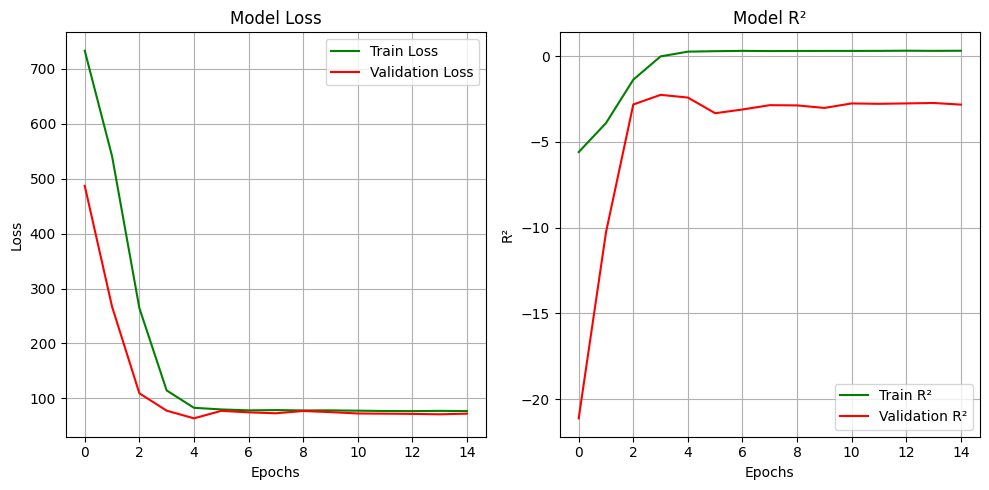

In [17]:
rcParams['figure.figsize'] = 10, 5

fig, ax = plt.subplots(1, 2)

ax[0].plot(history.history['loss'], 'g', label='Train Loss')
ax[0].plot(history.history['val_loss'], 'r', label='Validation Loss')
ax[0].set_title('Model Loss')
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('Epochs')
ax[0].legend(loc='upper right')
ax[0].grid(True)

ax[1].plot(history.history['r2_score'], 'g', label='Train R²')
ax[1].plot(history.history['val_r2_score'], 'r', label='Validation R²')
ax[1].set_title('Model R²')
ax[1].set_ylabel('R²')
ax[1].set_xlabel('Epochs')
ax[1].legend(loc='lower right')
ax[1].grid(True)

plt.tight_layout()
plt.show()

#### Model 2

In [19]:
model2 = Sequential()
model2.add(LSTM(128, input_shape=(X_train_scaled.shape[1], 1), activation='relu'))
model2.add(Dropout(0.3))
model2.add(Dense(1, activation='linear'))  # Single output for motor_UPDRS
model2.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=[r2_score])

/Users/behnazrezaeifar/Documents/Documents - Behnaz’s MacBook Pro/biosignals/biosignal/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [20]:
history2 = model2.fit(X_train_scaled, y_train_motor, epochs=100, batch_size=32, validation_data=(X_test_scaled, y_test_motor),
                    callbacks=[lr_scheduler, early_stopping], verbose=1)

Epoch 1/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 44398.7422 - r2_score: -649.1746 - val_loss: 390.4115 - val_r2_score: -277.8701 - learning_rate: 0.0010
Epoch 2/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 533.8683 - r2_score: -6.5619 - val_loss: 382.0794 - val_r2_score: -271.3306 - learning_rate: 0.0010
Epoch 3/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 517.8844 - r2_score: -6.3577 - val_loss: 372.5353 - val_r2_score: -264.0060 - learning_rate: 0.0010
Epoch 4/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 528.6516 - r2_score: -6.5806 - val_loss: 372.6697 - val_r2_score: -263.7872 - learning_rate: 0.0010
Epoch 5/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 509.2210 - r2_score: -6.1700 - val_loss: 367.2937 - val_r2_score: -259.5584 - learning_rate: 0.0010
Epoch 6/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 506.7127 - r2_score: -6.3701 - val_loss: 361.6118 - val_r2_score: -255.0595 - learning_rate: 0.0010
Epoch 7/100
135/135 ━━━━━━━━━━

In [21]:
test_loss2 = model2.evaluate(X_test_scaled, y_test_motor)

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 41.4951 - r2_score: -46.0119


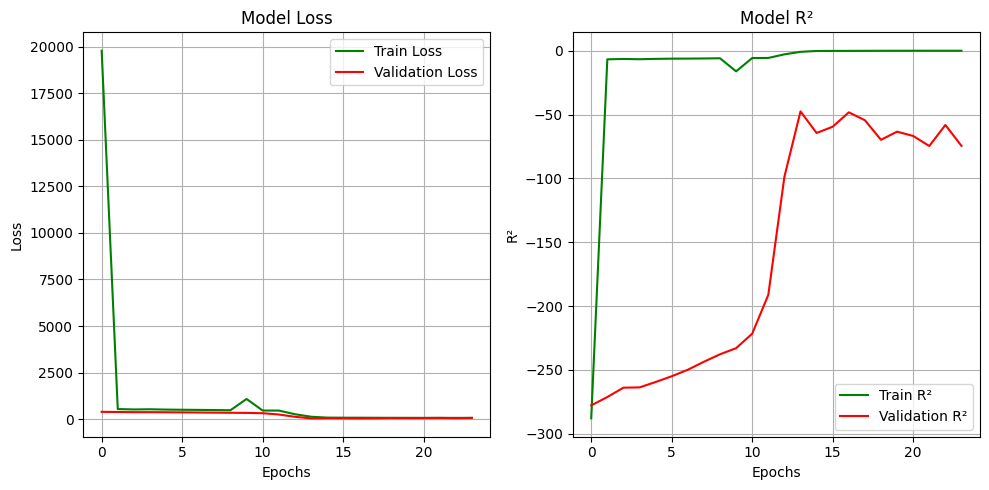

In [22]:
rcParams['figure.figsize'] = 10, 5
fig, ax = plt.subplots(1, 2)
ax[0].plot(history2.history['loss'], 'g', label='Train Loss')
ax[0].plot(history2.history['val_loss'], 'r', label='Validation Loss')
ax[0].set_title('Model Loss')
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('Epochs')
ax[0].legend(loc='upper right')
ax[0].grid(True)
ax[1].plot(history2.history['r2_score'], 'g', label='Train R²')
ax[1].plot(history2.history['val_r2_score'], 'r', label='Validation R²')
ax[1].set_title('Model R²')
ax[1].set_ylabel('R²')
ax[1].set_xlabel('Epochs')
ax[1].legend(loc='lower right')
ax[1].grid(True)
plt.tight_layout()
plt.show()

### Seperate Targets

#### motor_UPDRS

In [23]:
motor_model = Sequential()
motor_model.add(Dense(256, input_dim=X_train_scaled.shape[1], activation='relu'))
motor_model.add(BatchNormalization())
motor_model.add(Dropout(0.3))
motor_model.add(Dense(128, activation='relu'))
motor_model.add(BatchNormalization())
motor_model.add(Dropout(0.3))
motor_model.add(Dense(64, activation='relu'))
motor_model.add(BatchNormalization())
motor_model.add(Dense(1, activation='linear')) 

/Users/behnazrezaeifar/Documents/Documents - Behnaz’s MacBook Pro/biosignals/biosignal/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [24]:
motor_model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=[r2_score])

In [25]:
early_stopping_motor = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_scheduler_motor = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-6)


In [26]:
history_motor = motor_model.fit(X_train_scaled, y_train_motor, epochs=100, batch_size=32,
                    validation_data=(X_test_scaled, y_test_motor),
                    callbacks=[lr_scheduler_motor, early_stopping_motor], verbose=1)

Epoch 1/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 530.3480 - r2_score: -6.6206 - val_loss: 297.4108 - val_r2_score: -223.4448 - learning_rate: 0.0010
Epoch 2/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 789us/step - loss: 359.4449 - r2_score: -4.2639 - val_loss: 182.8798 - val_r2_score: -134.9595 - learning_rate: 0.0010
Epoch 3/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 778us/step - loss: 161.6645 - r2_score: -1.4545 - val_loss: 93.4362 - val_r2_score: -64.3521 - learning_rate: 0.0010
Epoch 4/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 760us/step - loss: 47.2779 - r2_score: 0.3366 - val_loss: 70.8987 - val_r2_score: -52.8696 - learning_rate: 0.0010
Epoch 5/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 775us/step - loss: 29.2188 - r2_score: 0.6020 - val_loss: 62.1157 - val_r2_score: -47.1860 - learning_rate: 0.0010
Epoch 6/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 757us/step - loss: 28.3004 - r2_score: 0.5964 - val_loss: 66.8569 - val_r2_score: -52.2273 - learning_rate: 0.0010
Epoch 7/100
135/135 ━━━━━━━━━━━━━━━━━━

In [27]:
motor_test_loss = motor_model.evaluate(X_test_scaled, y_test_motor)

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 515us/step - loss: 120.1407 - r2_score: -97.4231


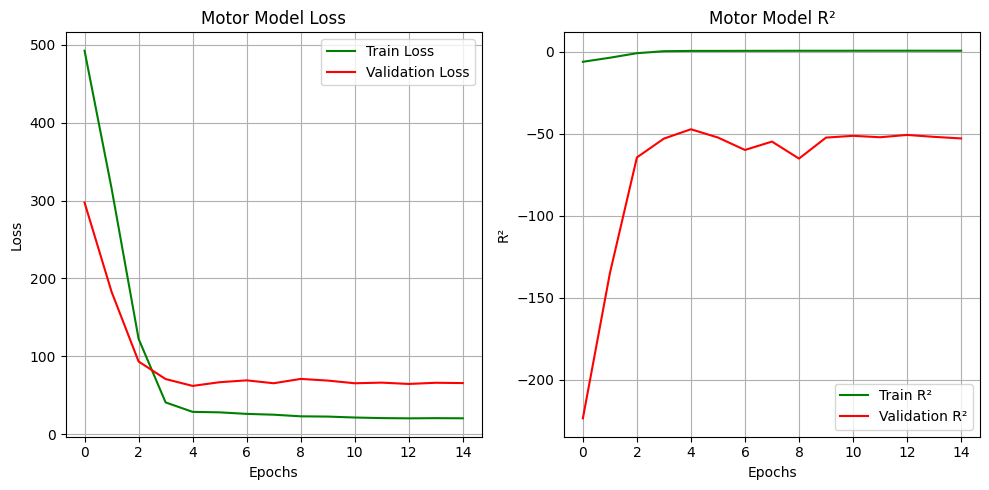

In [28]:
rcParams['figure.figsize'] = 10, 5
fig, ax = plt.subplots(1, 2)
ax[0].plot(history_motor.history['loss'], 'g', label='Train Loss')
ax[0].plot(history_motor.history['val_loss'], 'r', label='Validation Loss')
ax[0].set_title('Motor Model Loss')
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('Epochs')
ax[0].legend(loc='upper right')
ax[0].grid(True)
ax[1].plot(history_motor.history['r2_score'], 'g', label='Train R²')
ax[1].plot(history_motor.history['val_r2_score'], 'r', label='Validation R²')
ax[1].set_title('Motor Model R²')
ax[1].set_ylabel('R²')
ax[1].set_xlabel('Epochs')
ax[1].legend(loc='lower right')
ax[1].grid(True)
plt.tight_layout()
plt.show()

#### total_UPDRS

In [29]:
total_model = Sequential()
total_model.add(Dense(256, input_dim=X_train_scaled.shape[1], activation='relu'))
total_model.add(BatchNormalization())
total_model.add(Dropout(0.3))
total_model.add(Dense(128, activation='relu'))
total_model.add(BatchNormalization())
total_model.add(Dropout(0.3))
total_model.add(Dense(64, activation='relu'))
total_model.add(BatchNormalization())
total_model.add(Dense(1, activation='linear'))

/Users/behnazrezaeifar/Documents/Documents - Behnaz’s MacBook Pro/biosignals/biosignal/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [30]:
total_model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=[r2_score])

In [31]:
early_stopping_total = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_scheduler_total = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-6)

In [32]:
history_total = total_model.fit(X_train_scaled, y_train_total, epochs=100, batch_size=32,
                    validation_data=(X_test_scaled, y_test_total),
                    callbacks=[lr_scheduler_total, early_stopping_total], verbose=1)

Epoch 1/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 959.9437 - r2_score: -6.9964 - val_loss: 630.8153 - val_r2_score: -223.3891 - learning_rate: 0.0010
Epoch 2/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 764us/step - loss: 732.5815 - r2_score: -5.0861 - val_loss: 507.6105 - val_r2_score: -163.1243 - learning_rate: 0.0010
Epoch 3/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 754us/step - loss: 400.8667 - r2_score: -2.5390 - val_loss: 284.9959 - val_r2_score: -76.6942 - learning_rate: 0.0010
Epoch 4/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 748us/step - loss: 137.5007 - r2_score: -0.1692 - val_loss: 212.3328 - val_r2_score: -53.5683 - learning_rate: 0.0010
Epoch 5/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 749us/step - loss: 60.5444 - r2_score: 0.4907 - val_loss: 169.0478 - val_r2_score: -50.9567 - learning_rate: 0.0010
Epoch 6/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 753us/step - loss: 46.8818 - r2_score: 0.6081 - val_loss: 137.4783 - val_r2_score: -38.0587 - learning_rate: 0.0010
Epoch 7/100
135/135 ━━━━━━━━━━━━

In [33]:
total_test_loss = total_model.evaluate(X_test_scaled, y_test_total)

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 491us/step - loss: 236.9499 - r2_score: -56.7070


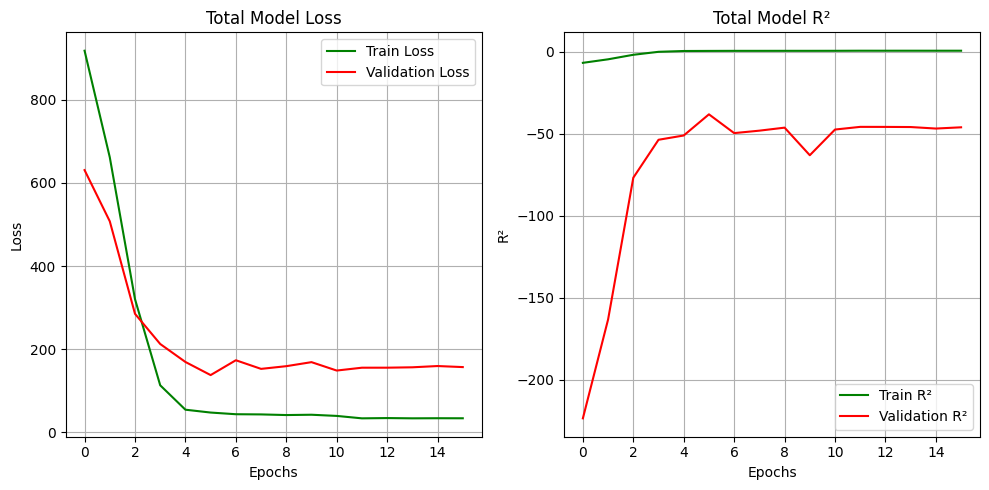

In [34]:
rcParams['figure.figsize'] = 10, 5
fig, ax = plt.subplots(1, 2)
ax[0].plot(history_total.history['loss'], 'g', label='Train Loss')
ax[0].plot(history_total.history['val_loss'], 'r', label='Validation Loss')
ax[0].set_title('Total Model Loss')
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('Epochs')
ax[0].legend(loc='upper right')
ax[0].grid(True)
ax[1].plot(history_total.history['r2_score'], 'g', label='Train R²')
ax[1].plot(history_total.history['val_r2_score'], 'r', label='Validation R²')
ax[1].set_title('Total Model R²')
ax[1].set_ylabel('R²')
ax[1].set_xlabel('Epochs')
ax[1].legend(loc='lower right')
ax[1].grid(True)
plt.tight_layout()
plt.show()